# Dry Bean

This dataset is from [UCI Machine Learning Repository](https://archive-beta.ics.uci.edu/ml/datasets/dry+bean+dataset).


In [1]:
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=True

## Setup
First, we load all the packages required for running the five algorithms and analyzing their performance.

In [2]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt

from sklearn import base
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from scipy.io import arff

from typing import Any
from typing import Union

import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

This dataset from UCI Data Repository has already been cleaned up and has no unknown values.

- Use the `preprocessing.OrdinalEncoder` module to encode the **Class** column
- Scale the features
- Split the data into **Training** and **Test** sets


In [5]:
data = pd.DataFrame(arff.loadarff('data/Dry_Bean_Dataset.arff')[0])

features = preprocessing.scale(data.drop(['Class'], axis=1))
target = data["Class"]

print(f"Number of samples: {target.size}")
print(
    f"Percentage of SEKER: {target.value_counts(normalize=True)[b'SEKER'] * 100:.3f}%")
print(
    f"Percentage of BARBUNYA: {target.value_counts(normalize=True)[b'BARBUNYA'] * 100:.3f}%")
print(
    f"Percentage of BOMBAY: {target.value_counts(normalize=True)[b'BOMBAY'] * 100:.3f}%")
print(
    f"Percentage of CALI: {target.value_counts(normalize=True)[b'CALI'] * 100:.3f}%")
print(
    f"Percentage of HOROZ: {target.value_counts(normalize=True)[b'HOROZ'] * 100:.3f}%")
print(
    f"Percentage of SIRA: {target.value_counts(normalize=True)[b'SIRA'] * 100:.3f}%")
print(
    f"Percentage of DERMASON: {target.value_counts(normalize=True)[b'DERMASON'] * 100:.3f}%")

data["Class"] = preprocessing.OrdinalEncoder().fit_transform(data[["Class"]])
target = data["Class"]

print("Splitting into train/test sets...", end="")
FEATURES_TRAIN, FEATURES_TEST, TARGET_TRAIN, TARGET_TEST = train_test_split(
    features, target, test_size=0.3, random_state=42)
print("Done")

print("Setting up global variables...", end="")
classifier_accuracy = np.zeros(6)
train_time = np.zeros(6)
infer_time = np.zeros(6)
print("Done")


Number of samples: 13611
Percentage of SEKER: 14.892%
Percentage of BARBUNYA: 9.713%
Percentage of BOMBAY: 3.835%
Percentage of CALI: 11.976%
Percentage of HOROZ: 14.165%
Percentage of SIRA: 19.367%
Percentage of DERMASON: 26.052%
Splitting into train/test sets...Done
Setting up global variables...Done


In [ ]:
TARGET_CLASSES = ['SEKER', 'BARBUNYA', 'BOMBAY',
                  'CALI', 'HOROZ', 'SIRA', 'DERMASON']


def plot_confusionmatrix(predicted, expected, dom) -> None:
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(predicted, expected)
    sns.heatmap(cf, annot=True, yticklabels=TARGET_CLASSES,
                xticklabels=TARGET_CLASSES, cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()


In [ ]:
ClassifierMixin = Union[DecisionTreeClassifier, MLPClassifier,
                        AdaBoostClassifier, SVC, KNeighborsClassifier]


def default_fit_test(classifier: ClassifierMixin) -> None:
    classifier.fit(FEATURES_TRAIN, TARGET_TRAIN)

    train_pred = classifier.predict(FEATURES_TRAIN)
    test_pred = classifier.predict(FEATURES_TEST)

    print(f'Train score {accuracy_score(train_pred, TARGET_TRAIN)}')
    print(f'Test score {accuracy_score(test_pred, TARGET_TEST)}')
    plot_confusionmatrix(train_pred, TARGET_TRAIN, dom='Train')
    plot_confusionmatrix(test_pred, TARGET_TEST, dom='Test')


In [ ]:
def grid_search_and_best_fit(classifier: ClassifierMixin, param_grid: dict[str, Any], index: int, name: str) -> GridSearchCV:
    classifier_best = GridSearchCV(
        classifier, param_grid=param_grid, cv=4)

    start_time = time.time()
    classifier_best.fit(FEATURES_TRAIN, TARGET_TRAIN)
    end_time = time.time()
    train_time[index] = end_time - start_time
    print(f"Best params for {name}: {classifier_best.best_params_}")

    return classifier_best


In [ ]:
def best_fit_test(classifier_best: GridSearchCV, index: int, name: str) -> None:
    best_train_pred = classifier_best.predict(FEATURES_TRAIN)
    print(
        f"Accuracy for best {name} on train sets: {accuracy_score(TARGET_TRAIN, best_train_pred)}")
    start_time = time.time()
    best_test_pred = classifier_best.predict(FEATURES_TEST)
    classifier_accuracy[index] = accuracy_score(TARGET_TEST, best_test_pred)
    end_time = time.time()
    infer_time[index] = end_time - start_time
    print(
        f"Accuracy for best {name} on test sets: {classifier_accuracy[0]}")

    plot_confusionmatrix(best_train_pred, TARGET_TRAIN,
                         dom="Train Set with Best Params")
    plot_confusionmatrix(best_test_pred, TARGET_TEST,
                         dom="Test Set with Best Params")


## Decision Tree


Train score 1.0
Test score 0.888099902056807
Train Confusion matrix


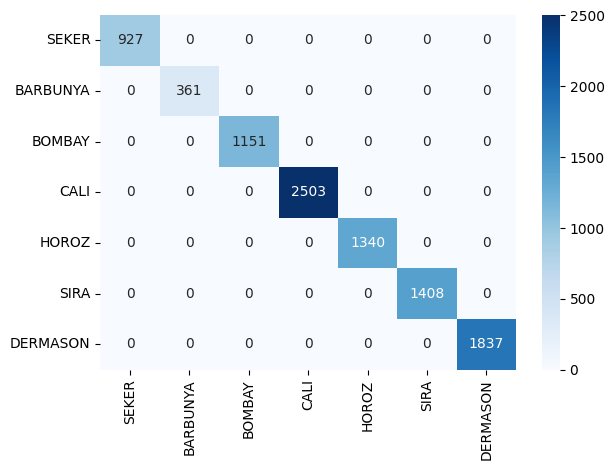

Test Confusion matrix


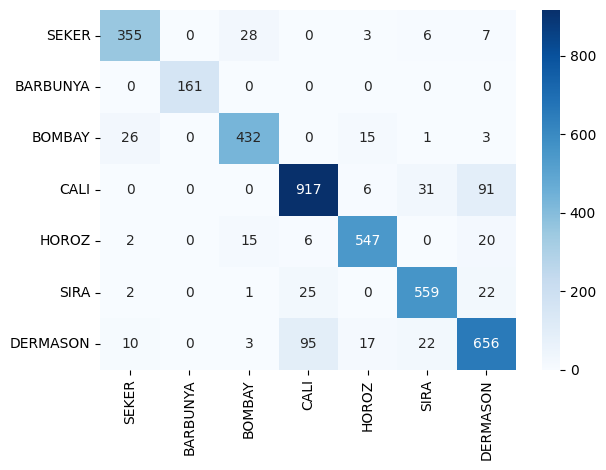

In [6]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
default_fit_test(decision_tree_classifier)


Before any study is done, a base case for the Decision Tree Classifier should be established, that is a Decision Tree Classifier with no pruning and no parameter tuning. As you can see from the confusion matrix and the accuaracy data, the decision tree can get 100% correct on the training set but merely 90% for the test set. This is a clear sign of overfitting. The decision tree is too complex and is not generalizing well.

## Tuning Maximum Depth and CCP-$\alpha$

To prevent over fitting, a maximum depth will be set as a pre-pruning method and CCP-$\alpha$ (Cost Complexoty Pruning) will be used for post-pruning. Thus, two parameters will be tuned: `max_depth` for the tree maxium depth and regularization parameter $\alpha$ for CCP. A higher value of $\alpha$ will prune more more nodes out of the tree.


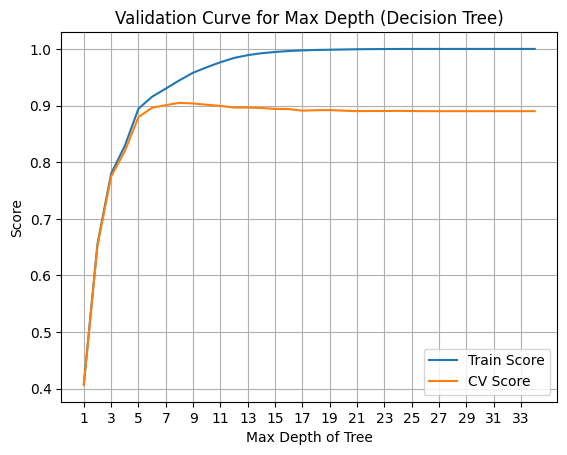

In [7]:
train_scores, test_scores = validation_curve(
    decision_tree_classifier, FEATURES_TRAIN, TARGET_TRAIN, param_range=np.arange(1, 35), param_name='max_depth', cv=4)

plt.figure()
plt.plot(np.arange(1, 35), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(1, 35), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Max Depth (Decision Tree)")
plt.xlabel("Max Depth of Tree")
plt.ylabel("Score")
plt.xticks(np.arange(1, 35, 2))
plt.grid()
plt.savefig('dry_bean_decision_tree_max_depth_validation_curve.png')
plt.show()


From the figure above, we can see that the training score converges to 1 as the maximum depth increases. This is because the tree is getting more and more complex and can fit the training data perfectly. However, the test score does not increase as much as the training score. Instead, the test score reaches its maximum when the `max_depth` reaches a certain value and then starts to decrease when overfitting starts kicking in. The best `max_depth` is 5.

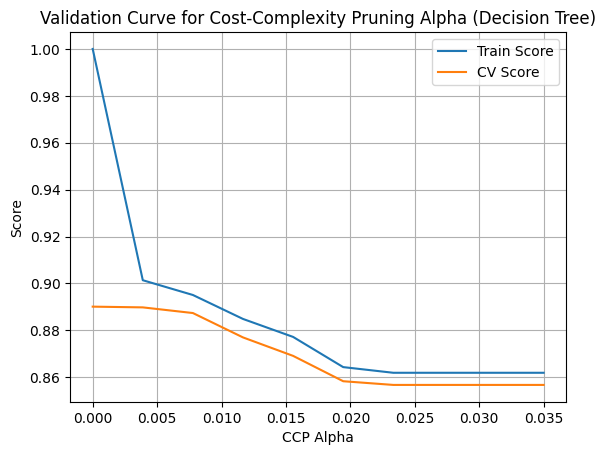

In [8]:
train_scores, test_scores = validation_curve(
    decision_tree_classifier, FEATURES_TRAIN, TARGET_TRAIN, param_range=np.linspace(0, 0.035, 10), param_name='ccp_alpha', cv=4)

plt.figure()
plt.plot(np.linspace(0, 0.035, 10), np.mean(
    train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0, 0.035, 10), np.mean(
    test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Cost-Complexity Pruning Alpha (Decision Tree)")
plt.xlabel("CCP Alpha")
plt.ylabel("Score")
plt.xticks(np.linspace(0, 0.035, 8))
plt.grid()
plt.savefig('dry_bean_decision_tree_ccp_alpha_validation_curve.png')
plt.show()


From the figure above, we can see the relationship of CCP-$\alpha$ with train score and the cross validation score. They both decreases as CCP-$\alpha$ increases, which means with the current dataset, no nodes should be pruned out using the Cross Complexity Pruning algorithm. The best $\alpha$ is 0.


In [9]:
param_grid = {'max_depth': np.arange(
    1, 35), 'ccp_alpha': np.linspace(0, 0.035, 10)}
decision_tree_classifier_best = grid_search_and_best_fit(
    decision_tree_classifier, param_grid, 0, "decision tree")


Best params for decision tree: {'ccp_alpha': 0.0, 'max_depth': 8}


In [ ]:
best_fit_test(decision_tree_classifier_best, 0, "decision tree")


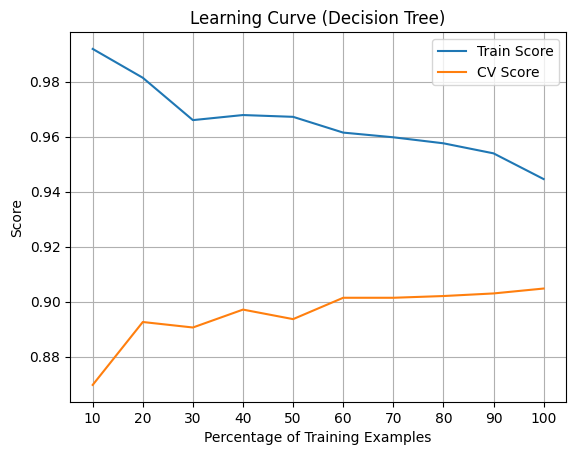

In [11]:
decision_tree_classifier_learning = DecisionTreeClassifier(
                                      random_state=42,
                                      max_depth=decision_tree_classifier_best.best_params_['max_depth'],
                                      ccp_alpha=decision_tree_classifier_best.best_params_['ccp_alpha']
                                    )
_, train_scores, test_scores = learning_curve(
    decision_tree_classifier_learning, FEATURES_TRAIN, TARGET_TRAIN, train_sizes=np.linspace(0.1, 1.0, 10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1, 1.0, 10)*100,
         np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1, 1.0, 10)*100,
         np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Decision Tree)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1, 1.0, 10)*100)
plt.grid()
plt.savefig('dry_bean_decision_tree_learning_curve.png')
plt.show()


## Neural Networks

Train score 0.9249501417025296
Test score 0.9211557296767875
Train Confusion matrix


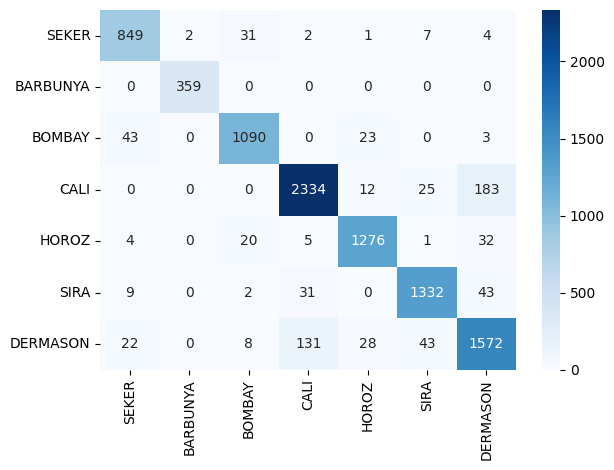

Test Confusion matrix


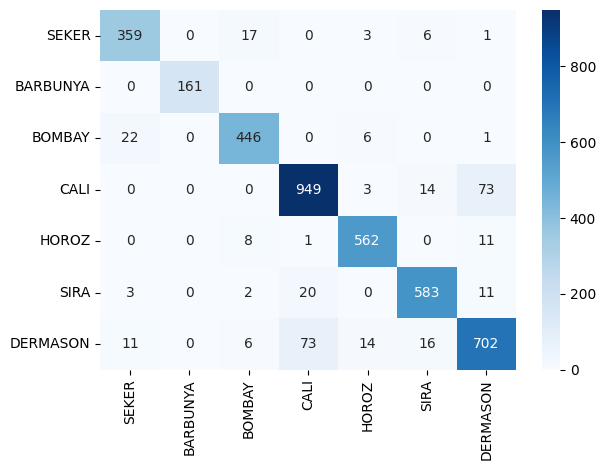

In [12]:
neural_network_classifier = MLPClassifier(
    hidden_layer_sizes=(4, 4), random_state=42, max_iter=2000)
default_fit_test(neural_network_classifier)


### Tuning Regularization $\alpha$ and Initial Learning Rate

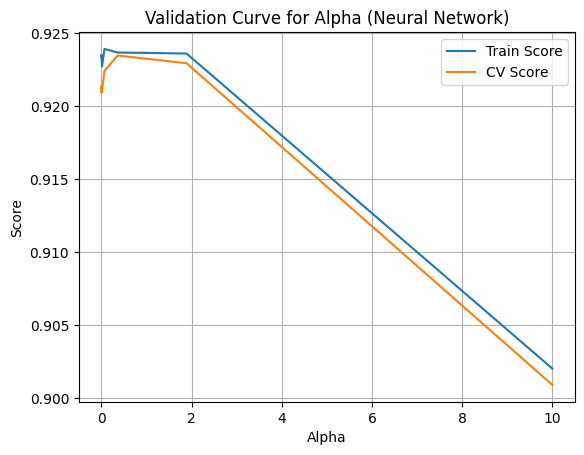

In [13]:
train_scores, test_scores = validation_curve(
    neural_network_classifier, FEATURES_TRAIN, TARGET_TRAIN, param_name="alpha", param_range=np.logspace(-20, 1, 30), cv=4)

plt.figure()
plt.plot(np.logspace(-20, 1, 30), np.mean(
    train_scores, axis=1), label='Train Score')
plt.plot(np.logspace(-20, 1, 30), np.mean(
    test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Alpha (Neural Network)")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.grid()
plt.savefig('dry_bean_decision_tree_neural_alpha_validation_curve.png')
plt.show()


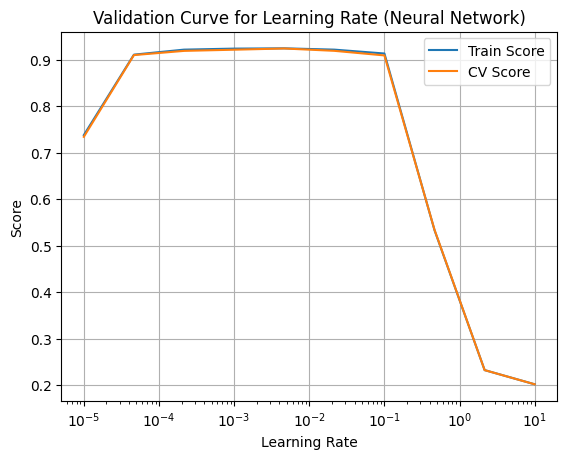

In [14]:
train_scores, test_scores = validation_curve(neural_network_classifier, FEATURES_TRAIN, TARGET_TRAIN,
    param_name="learning_rate_init", param_range=np.logspace(-5, 1, 10), cv=4)

plt.figure()
plt.semilogx(np.logspace(-5, 1, 10),
             np.mean(train_scores, axis=1), label='Train Score')
plt.semilogx(np.logspace(-5, 1, 10),
             np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Learning Rate (Neural Network)")
plt.xlabel("Learning Rate")
plt.ylabel("Score")
plt.grid()
plt.savefig('dry_bean_decision_tree_neural_learning_rate.png')
plt.show()


In [15]:
param_grid = {'alpha': np.logspace(-20, 1, 30),
              'learning_rate_init': np.logspace(-5, 1, 7)}
neural_network_classifier_best = grid_search_and_best_fit(
    neural_network_classifier, param_grid, 1, "neural network")


Best params for neural network: {'alpha': 0.35622478902624516, 'learning_rate_init': 0.01}


Accuracy for best multi-layer neural network on train sets: 0.9190721108428677
Accuracy for best multi-layer neural network on test sets: 0.9005876591576886
Train Set with Best Params Confusion matrix


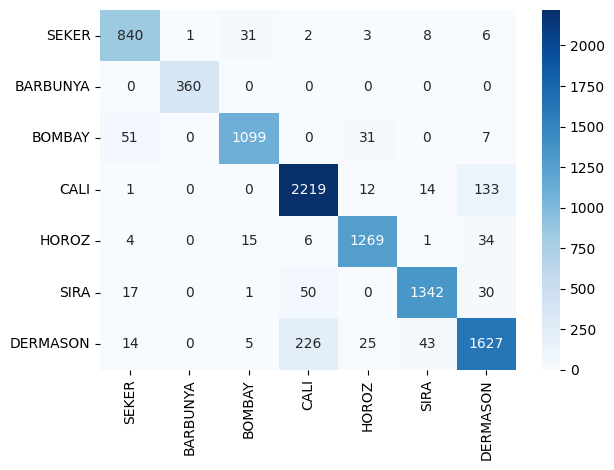

Test Set with Best Params Confusion matrix


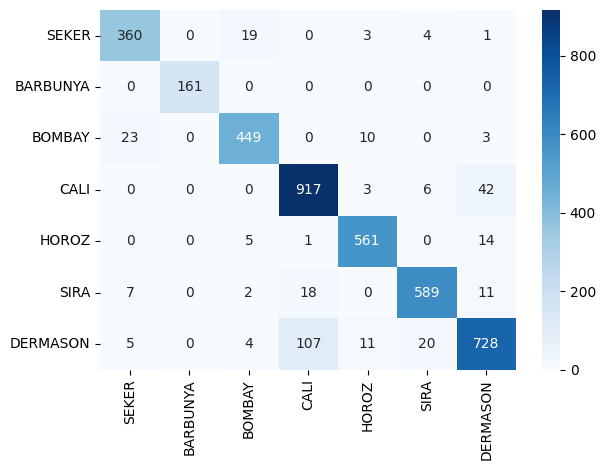

In [16]:
best_fit_test(neural_network_classifier_best, 1, "neural network")


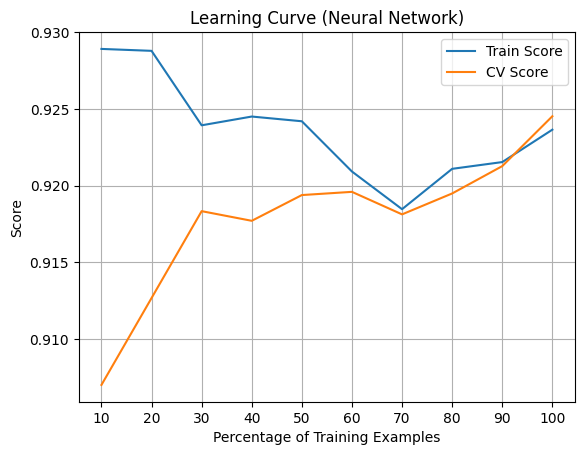

In [17]:
neural_network_classifier_learning = MLPClassifier(hidden_layer_sizes=(4, 4), random_state=42, max_iter=2000,
                                                   learning_rate_init=neural_network_classifier_best.best_params_[
                                                       'learning_rate_init'],
                                                   alpha=neural_network_classifier_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(
    neural_network_classifier_learning, FEATURES_TRAIN, TARGET_TRAIN, train_sizes=np.linspace(0.1, 1.0, 10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1, 1.0, 10)*100,
         np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1, 1.0, 10)*100,
         np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Neural Network)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1, 1.0, 10)*100)
plt.grid()
plt.savefig('dry_bean_neural_network_alpha_learning_rate_init_learning_curve.png')
plt.show()


### Training Loss and Score

In [18]:
neural_network_classifier = MLPClassifier(hidden_layer_sizes=(4, 4), random_state=42, max_iter=1, alpha=neural_network_classifier_best.best_params_[
                                          'alpha'], learning_rate_init=neural_network_classifier_best.best_params_['learning_rate_init'], warm_start=True)
epochs = 300
loss_training = np.zeros(epochs)
score_training = np.zeros(epochs)
score_validation = np.zeros(epochs)

features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
for epoch in range(epochs):
    neural_network_classifier.fit(features_train_train, target_train_train)

    score_training[epoch] = accuracy_score(
        target_train_train, neural_network_classifier.predict(features_train_train))
    score_validation[epoch] = accuracy_score(
        target_train_test, neural_network_classifier.predict(features_train_test))

    loss_training[epoch] = neural_network_classifier.loss_

score_test = accuracy_score(
    TARGET_TEST, neural_network_classifier.predict(FEATURES_TEST))
print("Test set accuracy:", score_test)


Test set accuracy: 0.9289911851126347


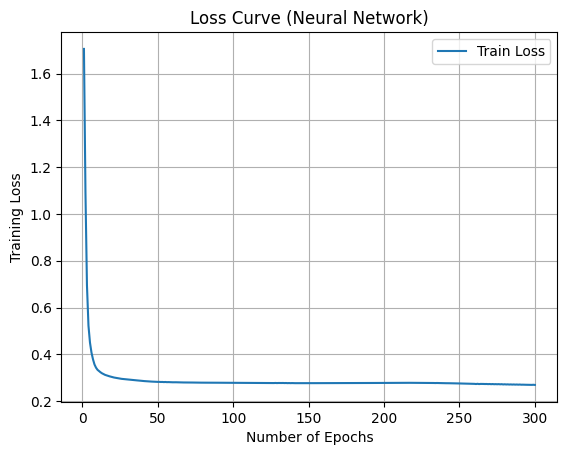

In [19]:
plt.figure()
plt.plot(np.arange(epochs) + 1, loss_training, label='Train Loss')
plt.legend()
plt.title("Loss Curve (Neural Network)")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.grid()
plt.savefig('dry_bean_neural_network_loss_curve.png')
plt.show()


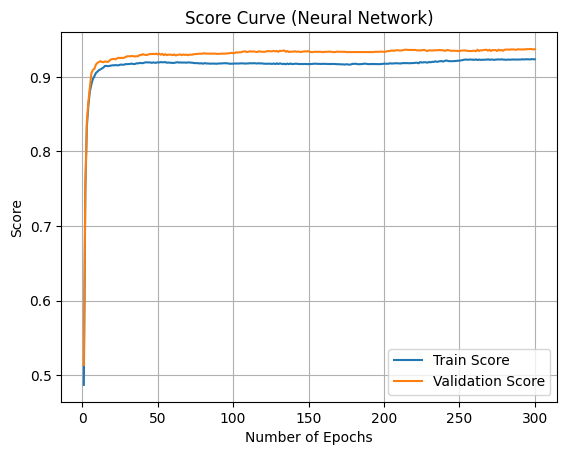

In [20]:
plt.figure()
plt.plot(np.arange(epochs) + 1, score_training, label='Train Score')
plt.plot(np.arange(epochs) + 1, score_validation, label='Validation Score')
plt.legend()
plt.title("Score Curve (Neural Network)")
plt.xlabel("Number of Epochs")
plt.ylabel("Score")
plt.grid()
plt.savefig('dry_bean_neural_network_score_curve.png')
plt.show()


### Tuning Regularization $\alpha$ and Hidden Layer Sizes (Single Layer Nerual Network)

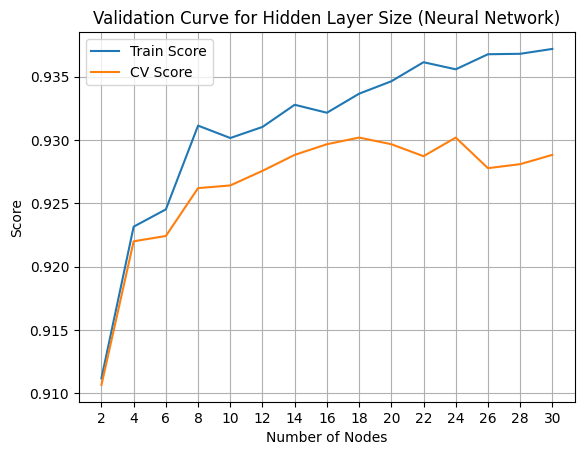

In [21]:
neural_network_classifier = MLPClassifier(random_state=42, max_iter=2000)
train_scores, test_scores = validation_curve(neural_network_classifier, FEATURES_TRAIN,
                                             TARGET_TRAIN, param_name="hidden_layer_sizes", param_range=np.arange(2, 31, 2), cv=4)

plt.figure()
plt.plot(np.arange(2, 31, 2), np.mean(
    train_scores, axis=1), label='Train Score')
plt.plot(np.arange(2, 31, 2), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Hidden Layer Size (Neural Network)")
plt.xlabel("Number of Nodes")
plt.ylabel("Score")
plt.grid()
plt.xticks(np.arange(2, 31, 2))
plt.savefig('dry_bean_neural_network_hidden_layer_validation_curve.png')
plt.show()


In [22]:
param_grid = {'alpha': np.logspace(-3, 3, 10),
              'hidden_layer_sizes': np.arange(2, 31, 2)}
neural_network_classifier_best = grid_search_and_best_fit(
    neural_network_classifier, param_grid, 2, "single layer neural network")


Best params for neural network: {'alpha': 0.001, 'hidden_layer_sizes': 24}


Accuracy for best single layer nerual network on train sets: 0.9356565550540569
Accuracy for best single layer nerual network on test sets: 0.9005876591576886
Train Set with Best Params Confusion matrix


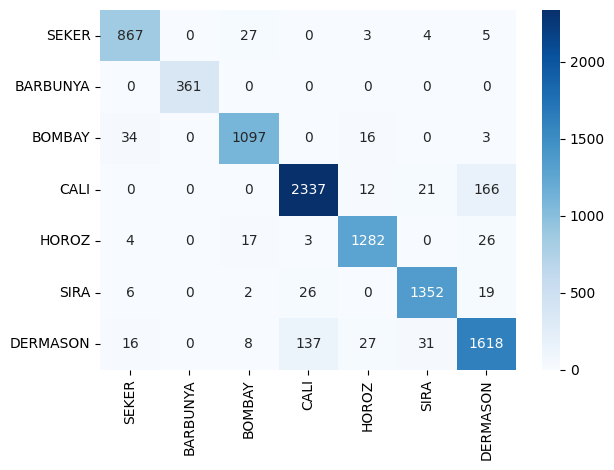

Test Set with Best Params Confusion matrix


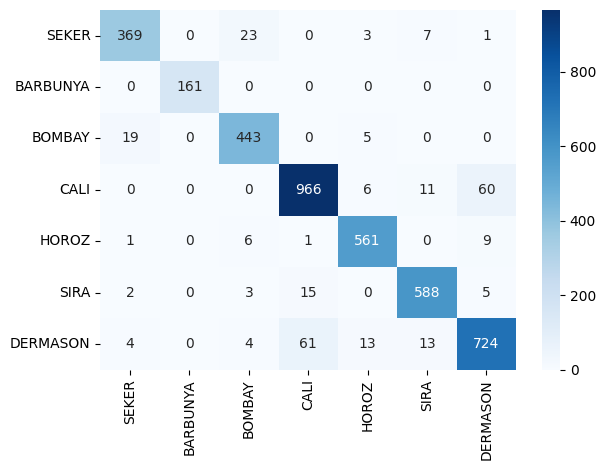

In [23]:
best_fit_test(neural_network_classifier_best, 2, "single layer neural network")


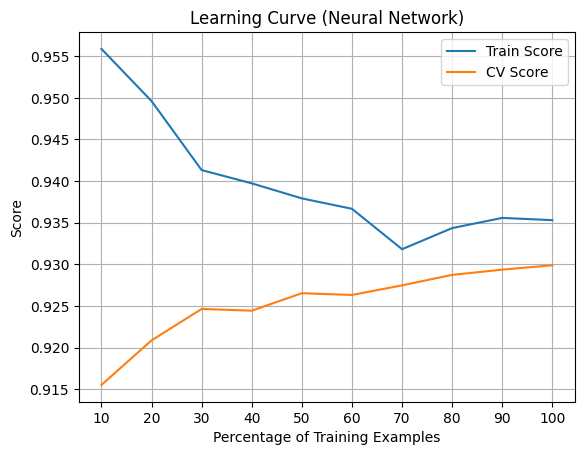

In [24]:
neural_network_classifier_learning = MLPClassifier(random_state=42, max_iter=2000,
                                                   hidden_layer_sizes=neural_network_classifier_best.best_params_[
                                                       'hidden_layer_sizes'],
                                                   alpha=neural_network_classifier_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(
    neural_network_classifier_learning, FEATURES_TRAIN, TARGET_TRAIN, train_sizes=np.linspace(0.1, 1.0, 10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1, 1.0, 10)*100,
         np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1, 1.0, 10)*100,
         np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Neural Network)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1, 1.0, 10)*100)
plt.grid()
plt.savefig('dry_bean_neural_network_alpha_hidden_layer_sizes_learning_curve.png')
plt.show()


## Boosting

Train score 0.6488926209719744
Test score 0.6466699314397649
Train Confusion matrix


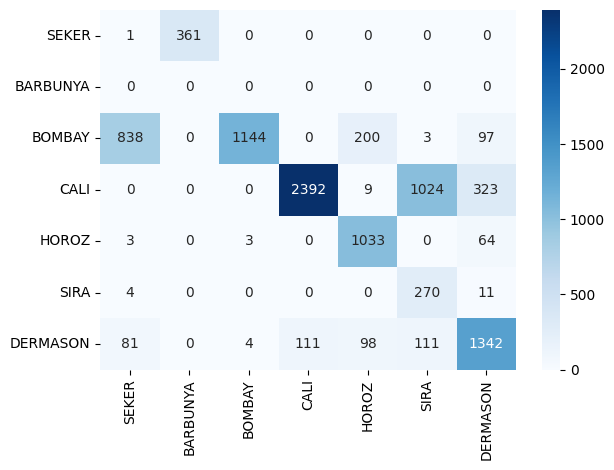

Test Confusion matrix


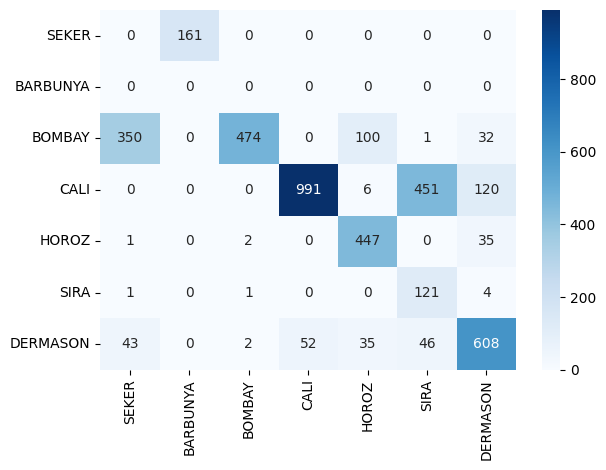

In [25]:
adaboost_classifier = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(
    max_depth=1, min_samples_leaf=1), random_state=42)
default_fit_test(adaboost_classifier)


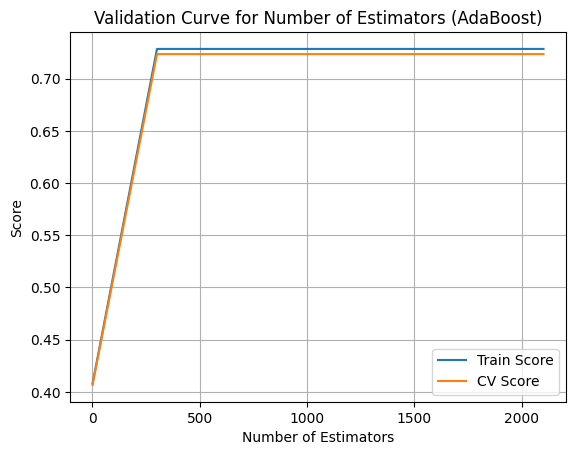

In [26]:
train_scores, test_scores = validation_curve(
    adaboost_classifier, FEATURES_TRAIN, TARGET_TRAIN, param_name="n_estimators", param_range=np.arange(1, 2102, 300), cv=4)

plt.figure()
plt.plot(np.arange(1, 2102, 300), np.mean(
    train_scores, axis=1), label='Train Score')
plt.plot(np.arange(1, 2102, 300), np.mean(
    test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Number of Estimators (AdaBoost)")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.grid()
plt.savefig('dry_bean_boosting_n_estimators_validation_curve.png')
plt.show()


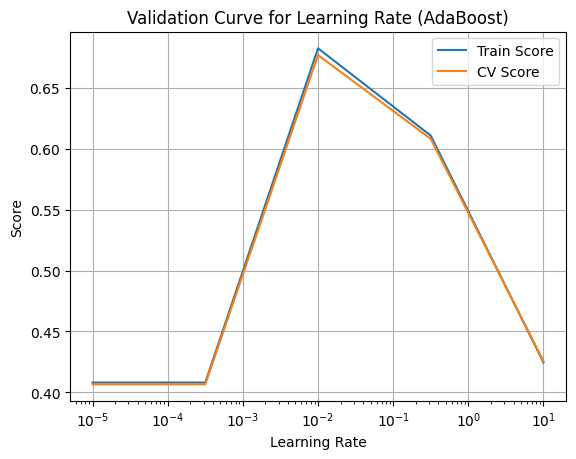

In [27]:
train_scores, test_scores = validation_curve(
    adaboost_classifier, FEATURES_TRAIN, TARGET_TRAIN, param_name="learning_rate", param_range=np.logspace(-5, 1, 5), cv=4)

plt.figure()
plt.semilogx(np.logspace(-5, 1, 5),
             np.mean(train_scores, axis=1), label='Train Score')
plt.semilogx(np.logspace(-5, 1, 5),
             np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Learning Rate (AdaBoost)")
plt.xlabel("Learning Rate")
plt.ylabel("Score")
plt.grid()
plt.savefig('dry_bean_boosting_learning_rate_validation_curve.png')
plt.show()


In [28]:
param_grid = {
    'learning_rate': np.logspace(-5, 1, 5), 'n_estimators': np.arange(1, 2102, 300)}
adaboost_classifier_best = grid_search_and_best_fit(
    adaboost_classifier, param_grid, 3, "adaboost")


Best params for AdaBoost: {'learning_rate': 0.31622776601683794, 'n_estimators': 301}


Accuracy for best adaboosting classifier on train sets: 0.6935026766033379
Accuracy for best adaboosting classifier on test sets: 0.9005876591576886
Train Set with Best Params Confusion matrix


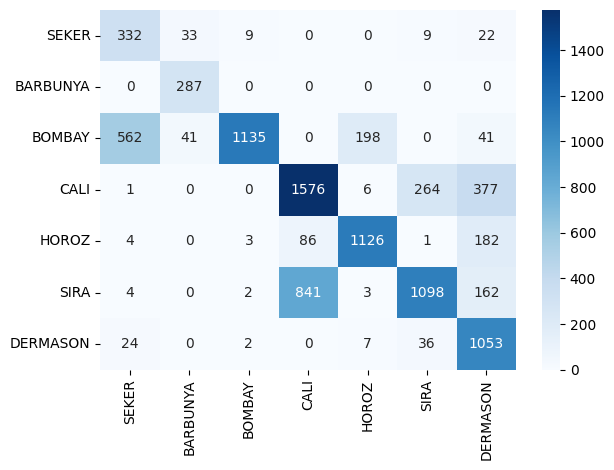

Test Set with Best Params Confusion matrix


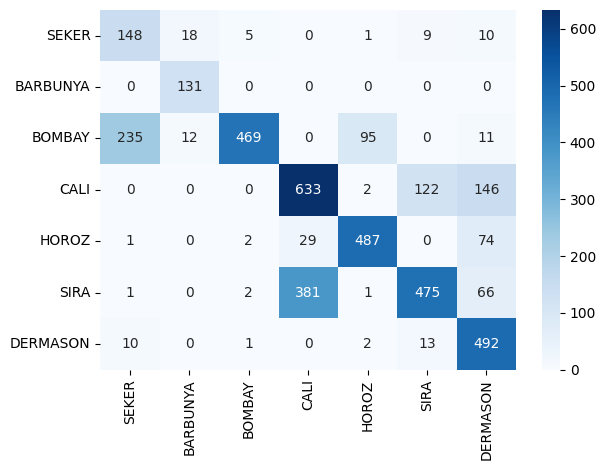

In [29]:
best_fit_test(adaboost_classifier_best, 3, "adaboost")


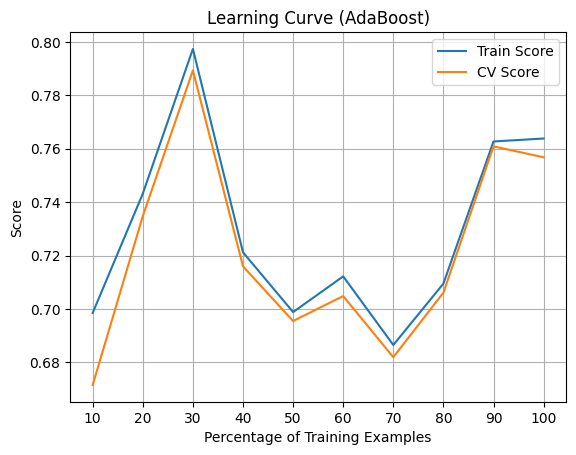

In [30]:
adaboost_classifier_learning_curve = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(
    max_depth=1, min_samples_leaf=1), random_state=42,
    n_estimators=adaboost_classifier_best.best_params_['n_estimators'],
    learning_rate=adaboost_classifier_best.best_params_['learning_rate'])
_, train_scores, test_scores = learning_curve(
    adaboost_classifier_learning_curve, FEATURES_TRAIN, TARGET_TRAIN, train_sizes=np.linspace(0.1, 1.0, 10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1, 1.0, 10)*100,
         np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1, 1.0, 10)*100,
         np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (AdaBoost)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1, 1.0, 10)*100)
plt.grid()
plt.savefig('dry_bean_boosting_learning_curve.png')
plt.show()


## SVM

Train score 0.9279941219691403
Test score 0.9260528893241919
Train Confusion matrix


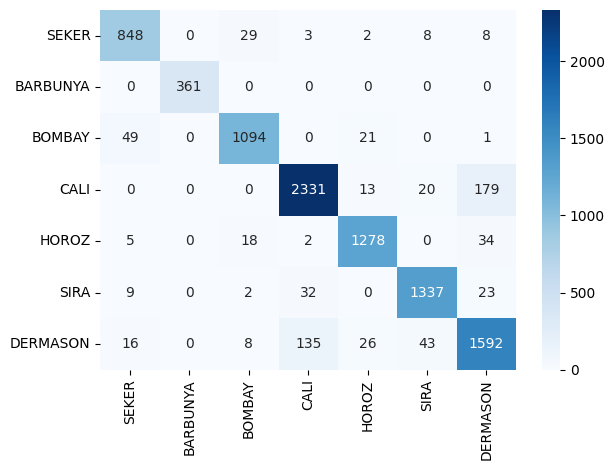

Test Confusion matrix


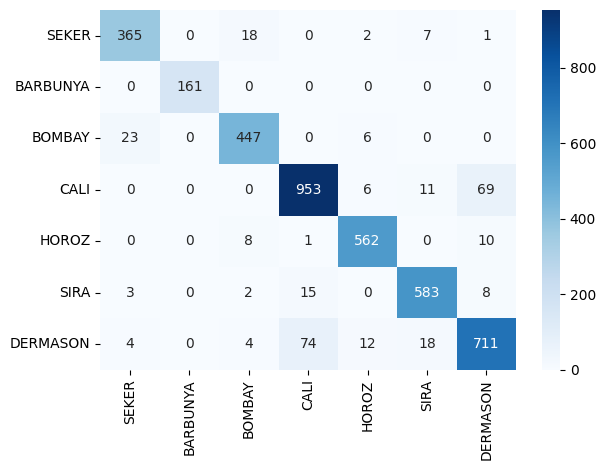

In [31]:
svm_classifier = SVC(kernel='linear', random_state=42)
default_fit_test(svm_classifier)


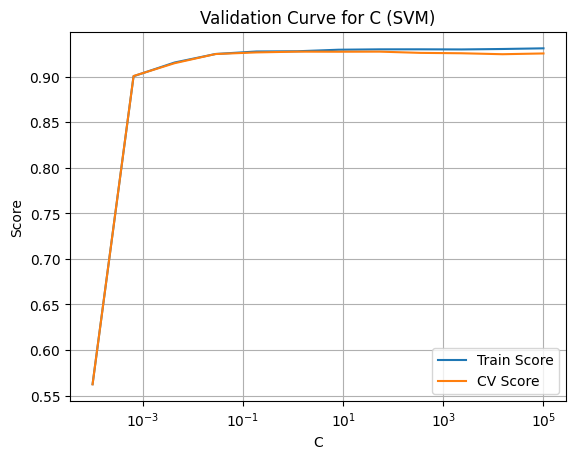

In [32]:
train_scores, test_scores = validation_curve(svm_classifier, FEATURES_TRAIN, TARGET_TRAIN, param_name="C", param_range=np.logspace(-4,5,12), cv=4)

plt.figure()
plt.semilogx(np.logspace(-4,5,12), np.mean(train_scores, axis=1), label='Train Score')
plt.semilogx(np.logspace(-4,5,12), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for C (SVM)")
plt.xlabel("C")
plt.ylabel("Score")
plt.grid()
plt.savefig('dry_bean_svm_c_validation_curve.png')
plt.show()

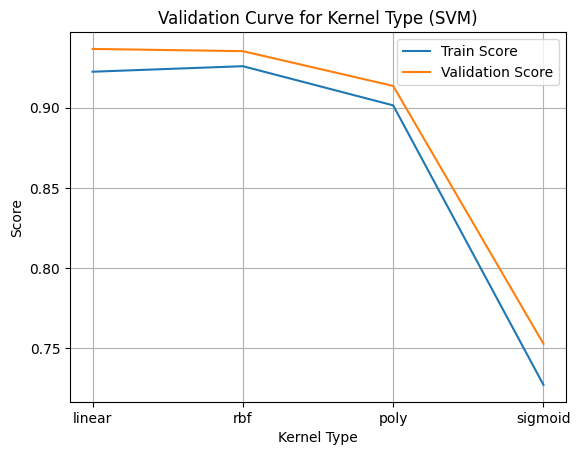

In [33]:
train_scores = np.zeros((4, 1))
test_scores = np.zeros((4, 1))

svm_classifier = svm.SVC(random_state=42, kernel='linear')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[0] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[0] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

svm_classifier = svm.SVC(random_state=42, kernel='rbf')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[1] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[1] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

svm_classifier = svm.SVC(random_state=42, kernel='poly')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[2] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[2] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

svm_classifier = svm.SVC(random_state=42, kernel='sigmoid')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[3] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[3] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

plt.figure()
plt.plot(np.arange(0, 4), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(0, 4), np.mean(
    test_scores, axis=1), label='Validation Score')
plt.legend()
plt.title("Validation Curve for Kernel Type (SVM)")
plt.xlabel("Kernel Type")
plt.ylabel("Score")
plt.grid()
plt.xticks(np.arange(4), ['linear', 'rbf', 'poly', 'sigmoid'])
plt.savefig('dry_bean_svm_kernel_validation_curve.png')
plt.show()


In [34]:
param_grid = {'C': np.logspace(-4, 5, 12),
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
svm_classifier_best = grid_search_and_best_fit(svm_classifier, param_grid, 4, "SVM")


Accuracy for best SVM classifier on train sets: 0.936601238585074
Accuracy for best SVM classifier on test sets: 0.9005876591576886
Train Set with Best Params Confusion matrix


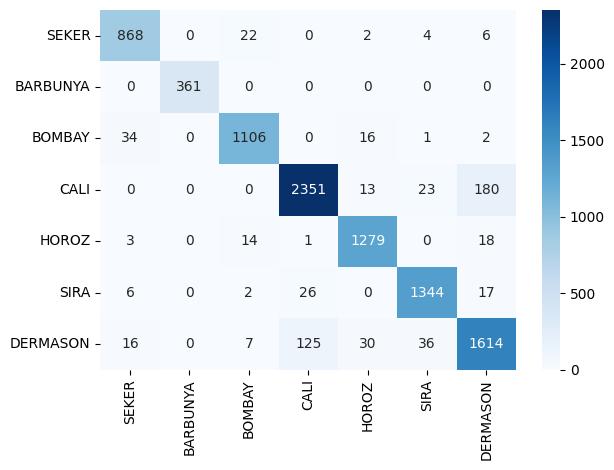

Test Set with Best Params Confusion matrix


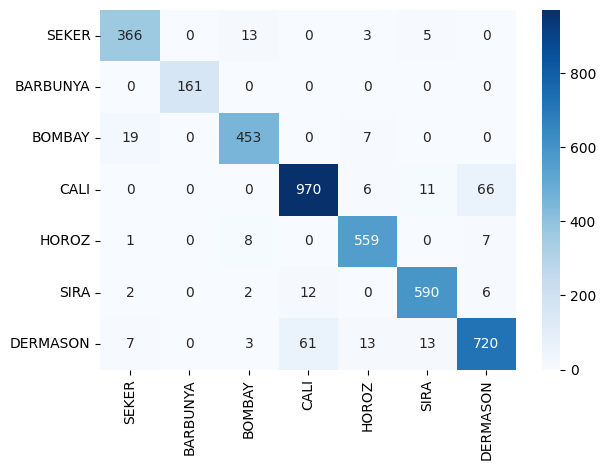

In [ ]:
best_fit_test(svm_classifier_best, 4, "SVM")


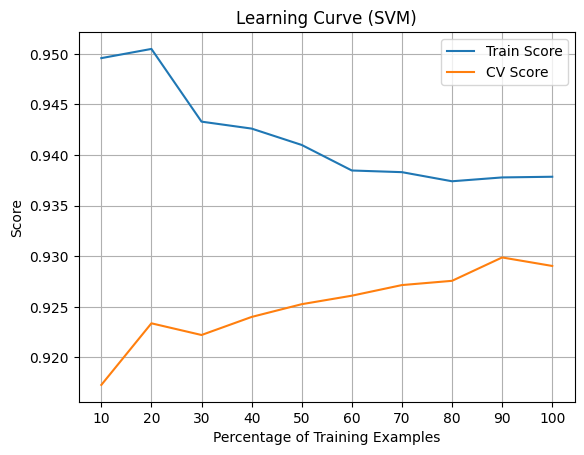

In [ ]:
svm_classifier_learning = svm.SVC(random_state=42, C=svm_classifier_best.best_params_[
                                  'C'], kernel=svm_classifier_best.best_params_['kernel'])
_, train_scores, test_scores = learning_curve(
    svm_classifier_learning, FEATURES_TRAIN, TARGET_TRAIN, train_sizes=np.linspace(0.1, 1.0, 10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1, 1.0, 10)*100,
         np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1, 1.0, 10)*100,
         np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (SVM)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1, 1.0, 10)*100)
plt.grid()
plt.savefig('dry_bean_svm_learning_curve.png')
plt.show()


## k-Nearest Neighbors

Train score 0.9415345859137189
Test score 0.9214005876591577
Train Confusion matrix


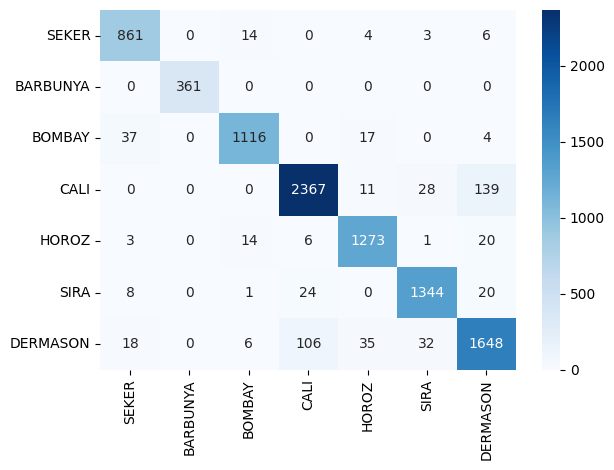

Test Confusion matrix


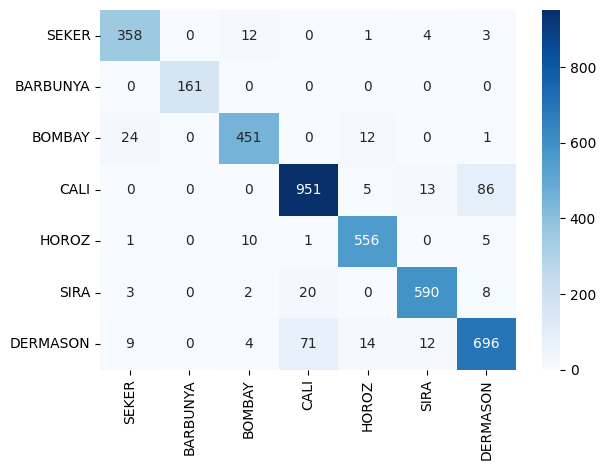

In [ ]:
knn_classifier = KNeighborsClassifier()
default_fit_test(knn_classifier)


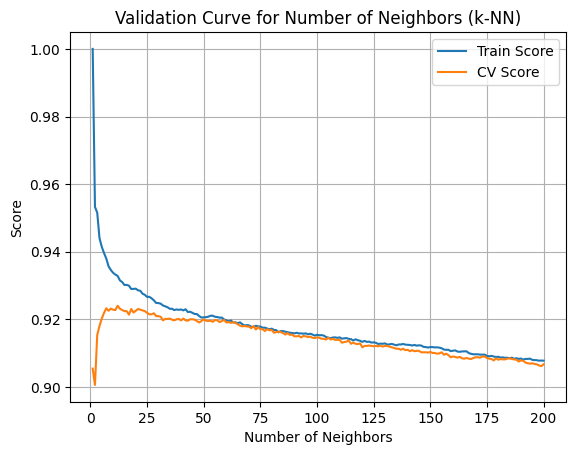

In [ ]:
train_scores, test_scores = validation_curve(
    knn_classifier, FEATURES_TRAIN, TARGET_TRAIN, param_range=np.arange(1, 201), param_name='n_neighbors', cv=4)

plt.figure()
plt.plot(np.arange(1, 201), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(1, 201), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Number of Neighbors (k-NN)")
plt.xlabel("Number of Neighbors")
plt.ylabel("Score")
plt.grid()
plt.savefig('dry_bean_knn_n_neighbors_validation_curve.png')
plt.show()


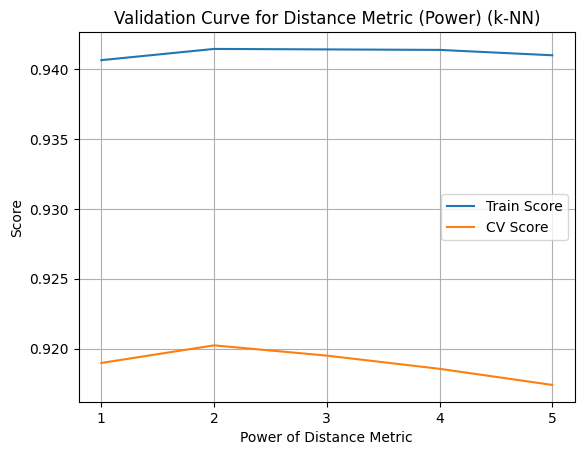

In [ ]:
train_scores, test_scores = validation_curve(
    knn_classifier, FEATURES_TRAIN, TARGET_TRAIN, param_name="p", param_range=np.arange(1, 6), cv=4)

plt.figure()
plt.plot(np.arange(1, 6), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(1, 6), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Distance Metric (Power) (k-NN)")
plt.xlabel("Power of Distance Metric")
plt.ylabel("Score")
plt.grid()
plt.xticks(np.arange(1, 6))
plt.savefig('dry_bean_knn_p_validation_curve.png')
plt.show()


In [ ]:
param_grid = {'n_neighbors': np.arange(1, 201), 'p': np.arange(1, 6)}
knn_classifier_best = grid_search_and_best_fit(
    knn_classifier, param_grid, 5, "k-NN")


Best params for k-NN: {'n_neighbors': 12, 'p': 2}


Accuracy for best k-NN classifier on train sets: 0.936601238585074
Accuracy for best k-NN classifier on test sets: 0.9005876591576886
Train Set with Best Params Confusion matrix


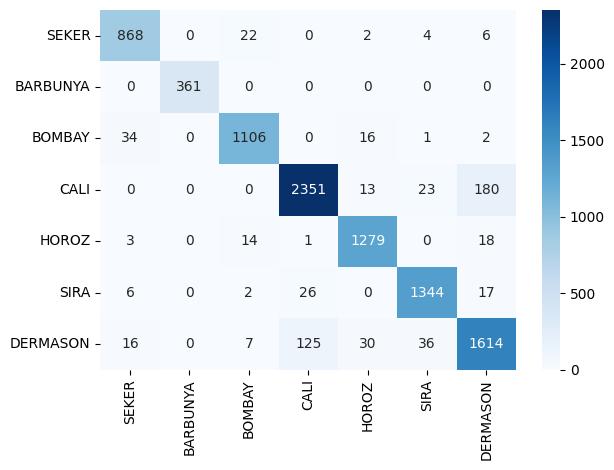

Test Set with Best Params Confusion matrix


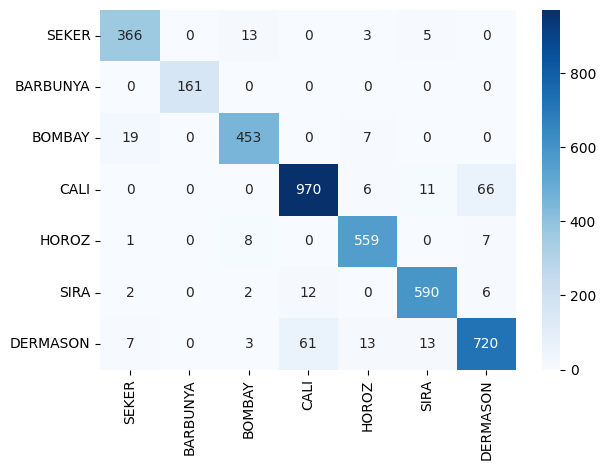

In [ ]:
best_fit_test(knn_classifier_best, 5, "k-NN")


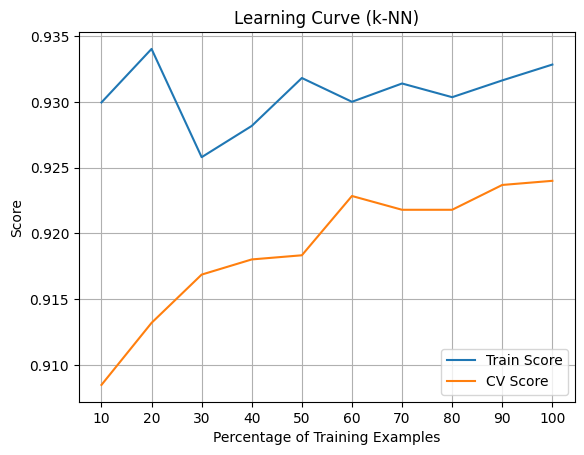

In [ ]:
knn_classifier_learning = KNeighborsClassifier(n_neighbors=knn_classifier_best.best_params_[
                                               'n_neighbors'], p=knn_classifier_best.best_params_['p'])
_, train_scores, test_scores = learning_curve(
    knn_classifier_learning, FEATURES_TRAIN, TARGET_TRAIN, train_sizes=np.linspace(0.1, 1.0, 10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1, 1.0, 10)*100,
         np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1, 1.0, 10)*100,
         np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (k-NN)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1, 1.0, 10)*100)
plt.grid()
plt.savefig('rice_knn_learning_curve.png')
plt.show()
